In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super(InceptionBlock, self).__init__()

        c_out = c_out//4

        # 1x1 convolution branch
        self.conv_1x1 = nn.Conv1d(c_in, c_out, kernel_size=1)

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv1d(c_in, c_out, kernel_size=1),
            nn.Conv1d(c_out, c_out, kernel_size=3, padding=1),
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv1d(c_in, c_out, kernel_size=1),
            nn.Conv1d(c_out, c_out, kernel_size=5, padding=2),
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, padding=1, stride=1),
            nn.Conv1d(c_in, c_out, kernel_size=1),
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

class Bi_GRU_I(nn.Module):
    def __init__(self, nc_input, n_classes):
        super(Bi_GRU_I, self).__init__()
        self.hidden_dim = 64

        self.gru_cell_f_1 = nn.GRUCell(nc_input, hidden_size=64)
        self.gru_cell_b_1 = nn.GRUCell(nc_input, hidden_size=64)
        self.gru_cell_f_2 = nn.GRUCell(128, hidden_size=64)
        self.gru_cell_b_2 = nn.GRUCell(128, hidden_size=64)

        self.conv1 = InceptionBlock(128,128)
        self.conv2 = InceptionBlock(128,128)
        self.conv3 = InceptionBlock(128,128)
        
        self.fc = nn.Linear(128, n_classes)
    
    def forward(self, x):
        #x = torch.transpose(x, 1, 2)
        hx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        output_f = []
        for t in range(x.size(2)):
            hx = self.gru_cell_f_1(x[:,:,t], hx)
            output_f.append(hx)

        x = x.flip(2)
        
        hx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        output_b = []
        for t in range(x.size(2)):
            hx = self.gru_cell_b_1(x[:,:,t], hx)
            output_b.append(hx)
        
        output_f = torch.stack((output_f), dim=2)
        output_b = torch.stack((output_b), dim=2)
        x = torch.cat((output_f, output_b), dim=1)

        hx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        output_f = []
        for t in range(x.size(2)):
            hx = self.gru_cell_f_2(x[:,:,t], hx)
            output_f.append(hx)

        x = x.flip(2)
        
        hx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        output_b = []
        for t in range(x.size(2)):
            hx = self.gru_cell_b_2(x[:,:,t], hx)
            output_b.append(hx)

        output_f = torch.stack((output_f), dim=2)
        output_b = torch.stack((output_b), dim=2)
        x = torch.cat((output_f, output_b), dim=1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = F.adaptive_avg_pool1d(x,1)
        x = x.view(x.size(0), -1)
        
        logits = self.fc(x)

        return logits


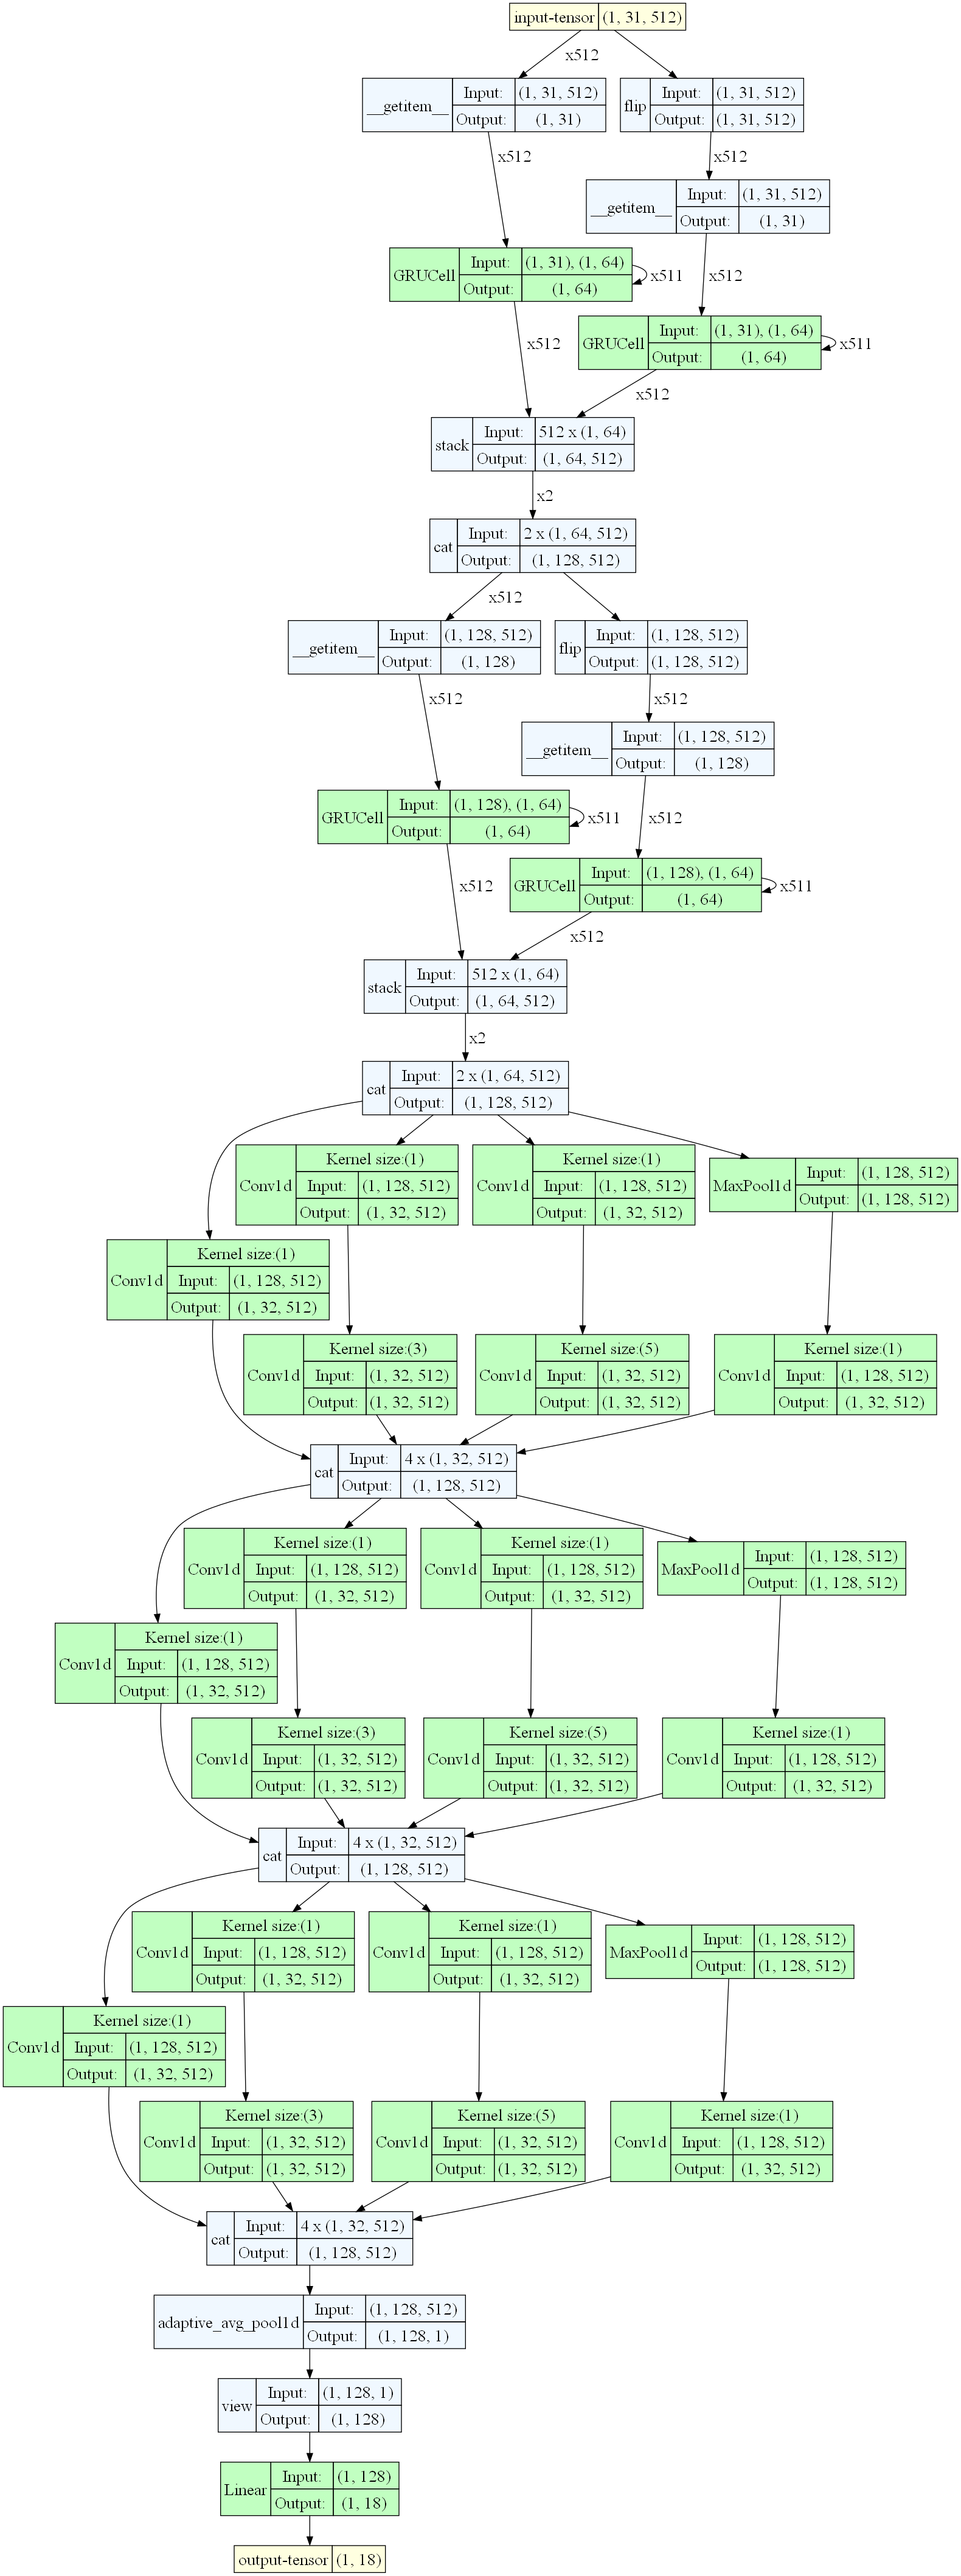

In [2]:
from utils import data_info
# import os
# os.environ["PATH"]+=os.pathsep+'C:\\Program Files\\Graphviz\\bin'
import graphviz
graphviz.set_jupyter_format('png')

#dataset = "UCI_HAR"
#dataset = "UniMiB-SHAR"
#dataset = "OPPORTUNITY"
dataset = "PAMAP2"
#dataset = "DSADS"
#dataset = "KU-HAR"
#dataset = "REALDISP"


input_nc, segment_size, class_num = data_info(dataset)

net = Bi_GRU_I(input_nc, class_num)

from torchview import draw_graph

model_graph = draw_graph(net, input_size=(1, input_nc, segment_size), save_graph=True, filename="Bi-GRU-I", expand_nested=False, roll=True)
model_graph.visual_graph